In [ ]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import hstack
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import log_loss, confusion_matrix

sys.path.append(str(Path().resolve().parent))
from src.data_split import get_train_target, get_test_target, get_cv_target, get_train_data, get_test_data, get_cv_data
from src.get_incoded_df import get_gene_ohe, get_gene_rc, get_variation_rc, get_text_bow, get_text_tfidf

In [4]:
# define gene dataframes
train_gene_ohe, test_gene_ohe, cv_gene_ohe = get_gene_ohe()
X_train_gene_rc, X_test_gene_rc, X_cv_gene_rc = get_gene_rc()

# define variation dataframes
X_train_variation_rc, X_test_variation_rc, X_cv_variation_rc = get_variation_rc()

# define text dataframes
X_train_bow_scaled, X_test_bow_scaled, X_cv_bow_scaled = get_text_bow()
X_train_tfidf, X_test_tfidf, X_cv_tfidf = get_text_tfidf()

In [10]:

#Misc. functionns for ML models
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [22]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not

train_df = get_train_data()
test_df = get_test_data()
cv_df = get_cv_data()

def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['Text'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

<b>There are 4 data classifications to be used in Traning</b><br>
1. gene ohe, variation rc, text bow
2. gene ohe, variation rc, text tf-idf
3. gene rc, variation rc, text bow
4. gene rc, variation rc, text tf-idf

In [6]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_ohe_variation_rc = hstack((train_gene_ohe, X_train_variation_rc))
test_gene_ohe_variation_rc = hstack((test_gene_ohe, X_test_variation_rc))
cv_gene_ohe_variation_rc = hstack((cv_gene_ohe, X_cv_variation_rc))

train_gene_rc_variation_rc = np.hstack((X_train_gene_rc, X_train_variation_rc))
test_gene_rc_variation_rc = np.hstack((X_test_gene_rc, X_test_variation_rc))
cv_gene_rc_variation_rc = np.hstack((X_cv_gene_rc, X_cv_variation_rc))

# SET 1 : Gene OHE + Variation RC + Text BOW
X_train_geneOHE_variationRC_textBOW = hstack((train_gene_ohe_variation_rc, X_train_bow_scaled)).tocsr()
X_test_geneOHE_variationRC_textBOW = hstack((test_gene_ohe_variation_rc, X_test_bow_scaled)).tocsr()
X_cv_geneOHE_variationRC_textBOW = hstack((cv_gene_ohe_variation_rc, X_cv_bow_scaled)).tocsr()

# SET 2 : Gene OHE + Variation RC + Text TFIDF
X_train_geneOHE_variatinRC_textTFIDF = hstack((train_gene_ohe_variation_rc, X_train_tfidf)).tocsr()
X_text_geneOHE_variationRC_textTFIDF = hstack((test_gene_ohe_variation_rc, X_test_tfidf)).tocsr()
X_cv_geneOHE_variationRC_textTFIDF = hstack((cv_gene_ohe_variation_rc, X_cv_tfidf)).tocsr()

# SET 3 : Gene RC + Variation RC + Text BOW
X_train_geneRC_variationRC_textBOW = hstack((train_gene_rc_variation_rc, X_train_bow_scaled)).tocsr()
X_test_geneRC_variationRC_textBOW = hstack((test_gene_rc_variation_rc, X_test_bow_scaled)).tocsr()
X_cv_geneRC_variationRC_textBOW = hstack((cv_gene_rc_variation_rc, X_cv_bow_scaled)).tocsr()

# SET 4 : Gene RC + Variation RC + Text TFIDF
X_train_geneRC_variationRC_textTFIDF = hstack((train_gene_rc_variation_rc, X_train_tfidf)).tocsr()
X_test_geneRC_variationRC_textTFIDF = hstack((test_gene_rc_variation_rc, X_test_tfidf)).tocsr()
X_cv_geneRC_variationRC_textTFIDF = hstack((cv_gene_rc_variation_rc, X_cv_tfidf)).tocsr()


train_y = get_train_target()
test_y = get_test_target()
cv_y = get_cv_target()


In [8]:
print("SET 1 : Gene OHE + Variation RC + Text BOW :")
print("(number of data points * number of features) in train data = ", X_train_geneOHE_variationRC_textBOW.shape)
print("(number of data points * number of features) in test data = ", X_test_geneOHE_variationRC_textBOW.shape)
print("(number of data points * number of features) in cross validation data =", X_cv_geneOHE_variationRC_textBOW.shape)
print()
print("SET 2 : Gene OHE + Variation RC + Text TFIDF :")
print("(number of data points * number of features) in train data = ", X_train_geneOHE_variatinRC_textTFIDF.shape)
print("(number of data points * number of features) in test data = ", X_text_geneOHE_variationRC_textTFIDF.shape)
print("(number of data points * number of features) in cross validation data =", X_cv_geneOHE_variationRC_textTFIDF.shape)
print()
print("SET 3 : Gene RC + Variation RC + Text BOW :")
print("(number of data points * number of features) in train data = ", X_train_geneRC_variationRC_textBOW.shape)
print("(number of data points * number of features) in test data = ", X_test_geneRC_variationRC_textBOW.shape)
print("(number of data points * number of features) in cross validation data =", X_cv_geneRC_variationRC_textBOW.shape)
print()
print("SET 4 : Gene RC + Variation RC + Text TFIDF :")
print("(number of data points * number of features) in train data = ", X_train_geneRC_variationRC_textTFIDF.shape)
print("(number of data points * number of features) in test data = ", X_test_geneRC_variationRC_textTFIDF.shape)
print("(number of data points * number of features) in cross validation data =", X_cv_geneRC_variationRC_textTFIDF.shape)

SET 1 : Gene OHE + Variation RC + Text BOW :
(number of data points * number of features) in train data =  (2121, 52467)
(number of data points * number of features) in test data =  (664, 52467)
(number of data points * number of features) in cross validation data = (531, 52467)

SET 2 : Gene OHE + Variation RC + Text TFIDF :
(number of data points * number of features) in train data =  (2121, 467955)
(number of data points * number of features) in test data =  (664, 467955)
(number of data points * number of features) in cross validation data = (531, 467955)

SET 3 : Gene RC + Variation RC + Text BOW :
(number of data points * number of features) in train data =  (2121, 52241)
(number of data points * number of features) in test data =  (664, 52241)
(number of data points * number of features) in cross validation data = (531, 52241)

SET 4 : Gene RC + Variation RC + Text TFIDF :
(number of data points * number of features) in train data =  (2121, 467729)
(number of data points * numbe

<h2>Naive Bayes</h2>

<h3>SET 1 : Gene OHE + Variation RC + Text BOW</h3>

for alpha = 1e-05
Log Loss : 1.3509849358118158
for alpha = 0.0001
Log Loss : 1.3488934953677574
for alpha = 0.001
Log Loss : 1.3342328917249193
for alpha = 0.1
Log Loss : 1.32661239422472
for alpha = 1
Log Loss : 1.3178657827861455
for alpha = 10
Log Loss : 1.3244997346672798
for alpha = 100
Log Loss : 1.3575068567243465
for alpha = 1000
Log Loss : 1.4890829635203646


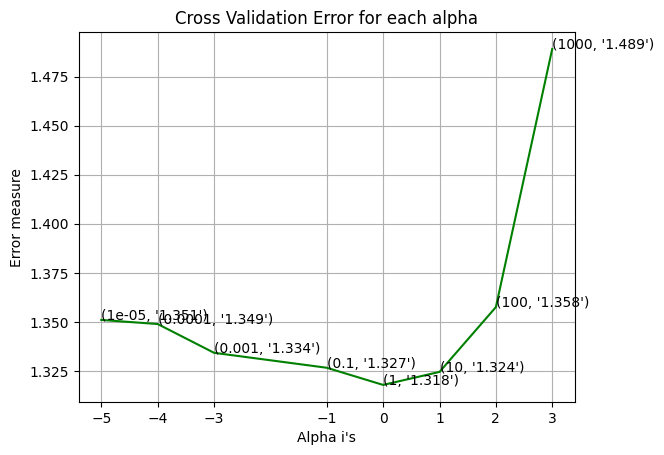

For values of best alpha =  1 The train log loss is: 0.9236277294852403
For values of best alpha =  1 The cross validation log loss is: 1.3178657827861455
For values of best alpha =  1 The test log loss is: 1.2663176558689575
Confusion matrix for cross validation data :
Log Loss : 1.3178657827861455
Number of missclassified point : 0.4086629001883239
-------------------- Confusion matrix --------------------


/tmp/ipykernel_113793/3717133345.py:22: RuntimeWarning: invalid value encountered in divide
  B =(C/C.sum(axis=0))


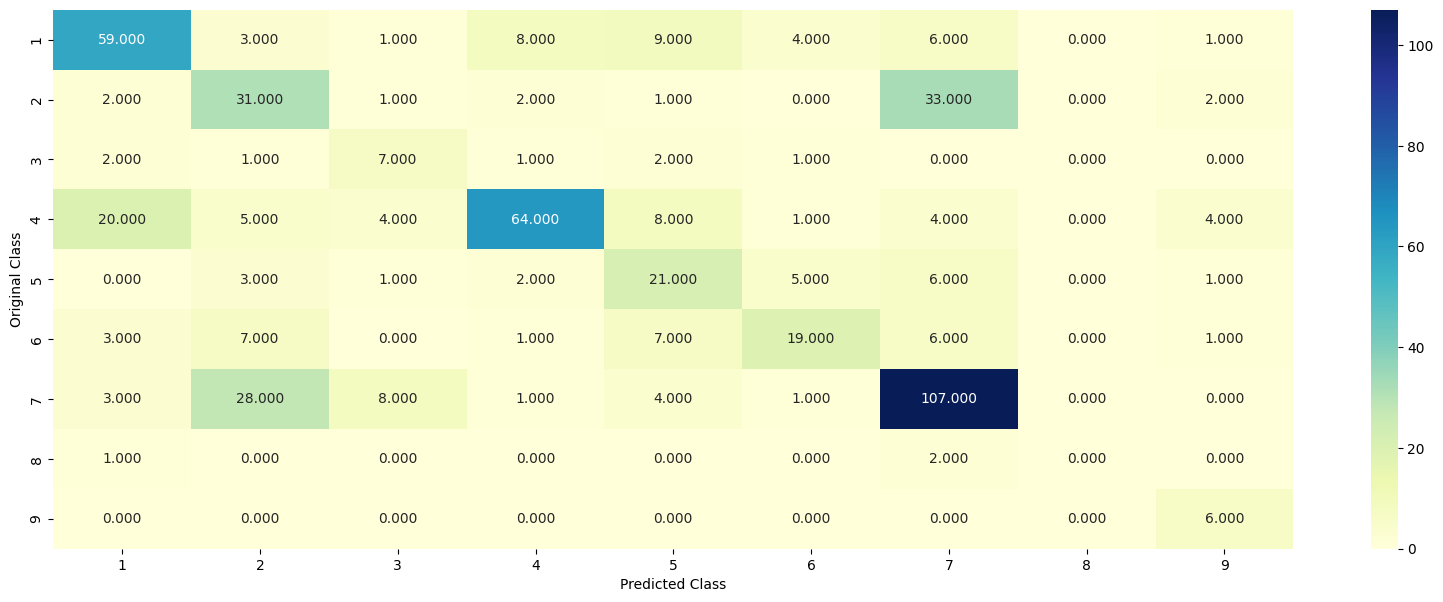

-------------------- Precision matrix (Columm Sum=1) --------------------


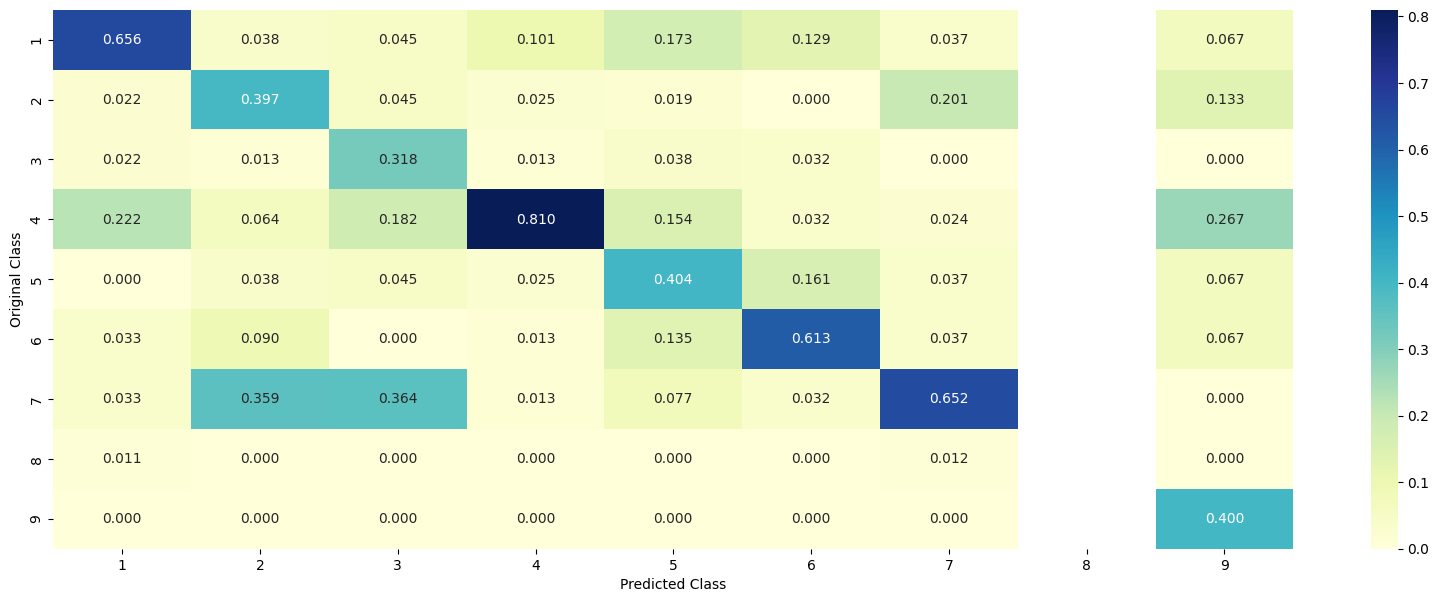

-------------------- Recall matrix (Row sum=1) --------------------


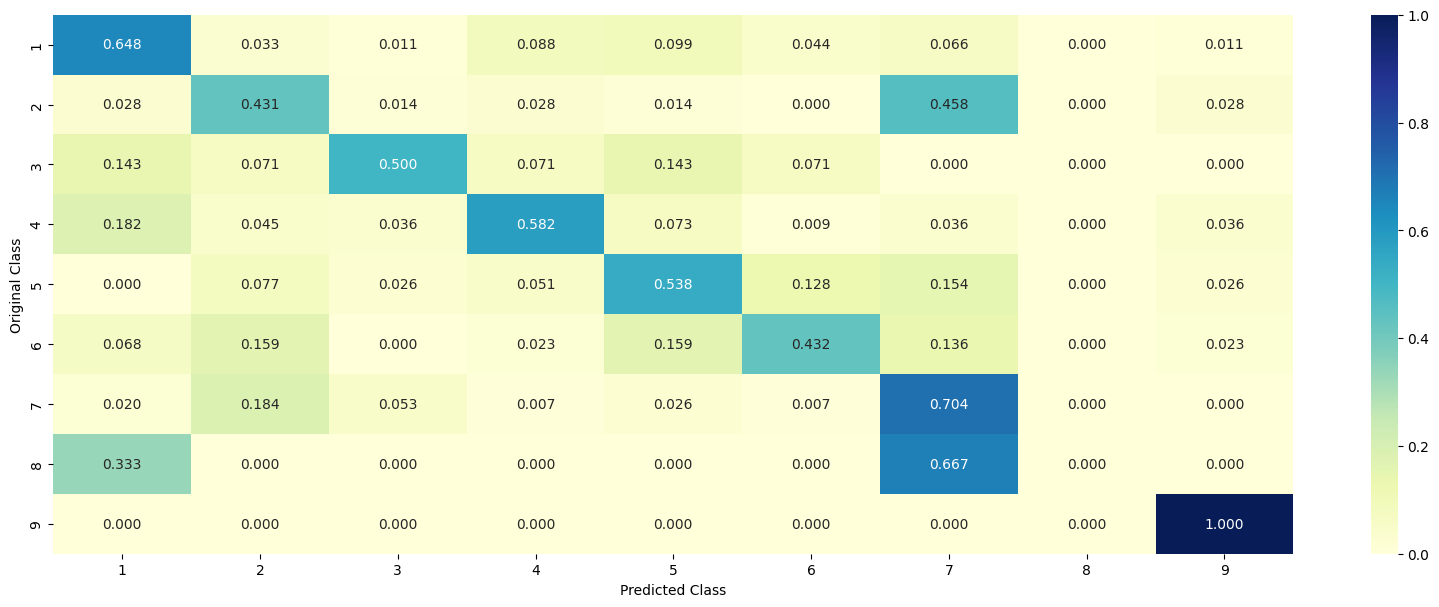

In [20]:
from sklearn.naive_bayes import MultinomialNB

alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    # clf.fit(X_cv_geneOHE_variationRC_textBOW, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_geneOHE_variationRC_textBOW, train_y)
    sig_clf_probs = sig_clf.predict_proba(X_cv_geneOHE_variationRC_textBOW)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=sig_clf.classes_))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_geneOHE_variationRC_textBOW, train_y)


predict_y = sig_clf.predict_proba(X_train_geneOHE_variationRC_textBOW)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_y, predict_y, labels=sig_clf.classes_))
predict_y = sig_clf.predict_proba(X_cv_geneOHE_variationRC_textBOW)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(cv_y, predict_y, labels=sig_clf.classes_))
predict_y = sig_clf.predict_proba(X_test_geneOHE_variationRC_textBOW)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_y, predict_y, labels=sig_clf.classes_))


print("Confusion matrix for cross validation data :")
sig_clf_probs = sig_clf.predict_proba(X_cv_geneOHE_variationRC_textBOW)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(X_cv_geneOHE_variationRC_textBOW)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(X_cv_geneOHE_variationRC_textBOW.toarray()))

In [41]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(X_test_geneOHE_variationRC_textBOW[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(X_test_geneOHE_variationRC_textBOW[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
# indices=np.argsort(-1*abs(sig_clf.coef_))[predicted_cls-1][:,:no_feature]
# indices=np.argsort(-1*abs(sig_clf.calibrated_classifiers_[0].base_estimator_.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
# get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.096  0.0796 0.0103 0.1126 0.0328 0.0311 0.6286 0.0049 0.0042]]
Actual Class : 7
--------------------------------------------------


In [45]:
test_point_index = 50
no_feature = 100
predicted_cls = sig_clf.predict(X_test_geneOHE_variationRC_textBOW[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(X_test_geneOHE_variationRC_textBOW[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
# indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
# print("-"*50)
# get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.1095 0.4212 0.0117 0.1284 0.0373 0.1425 0.139  0.0055 0.0048]]
Actual Class : 6
